In [1]:
# prompt: google drive
"""
from google.colab import drive
drive.mount('/content/drive')"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')"

/content


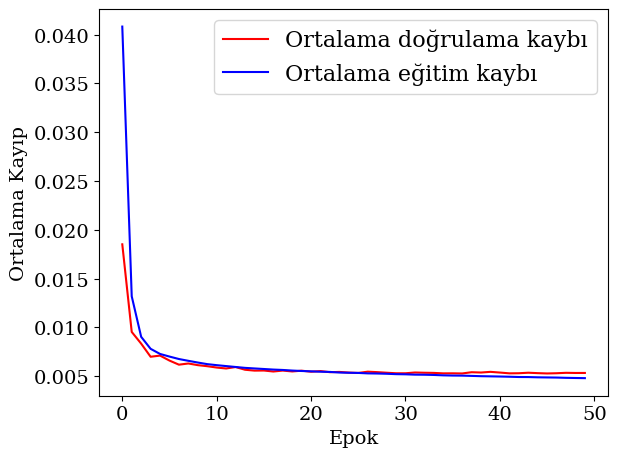

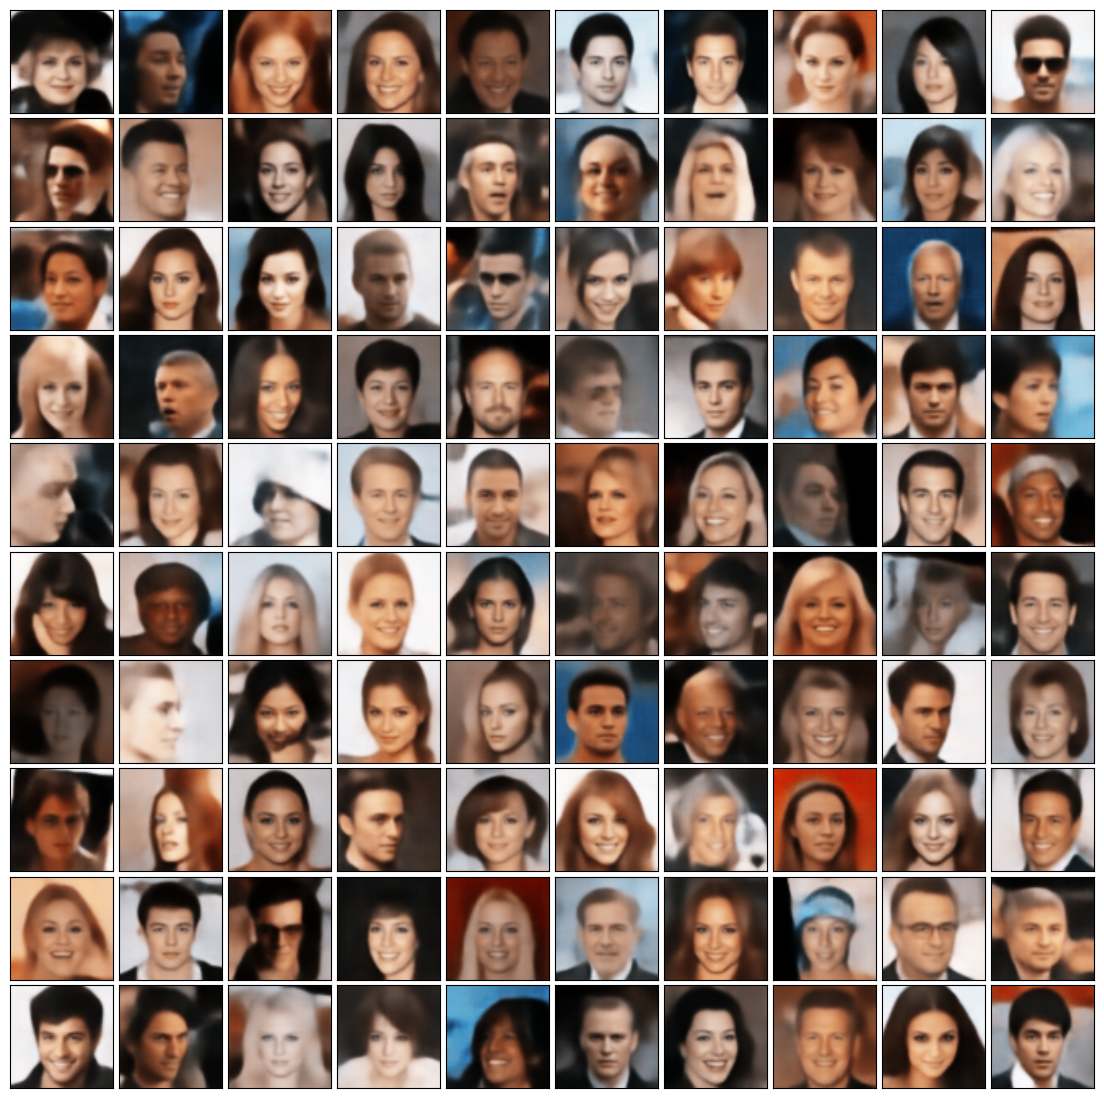

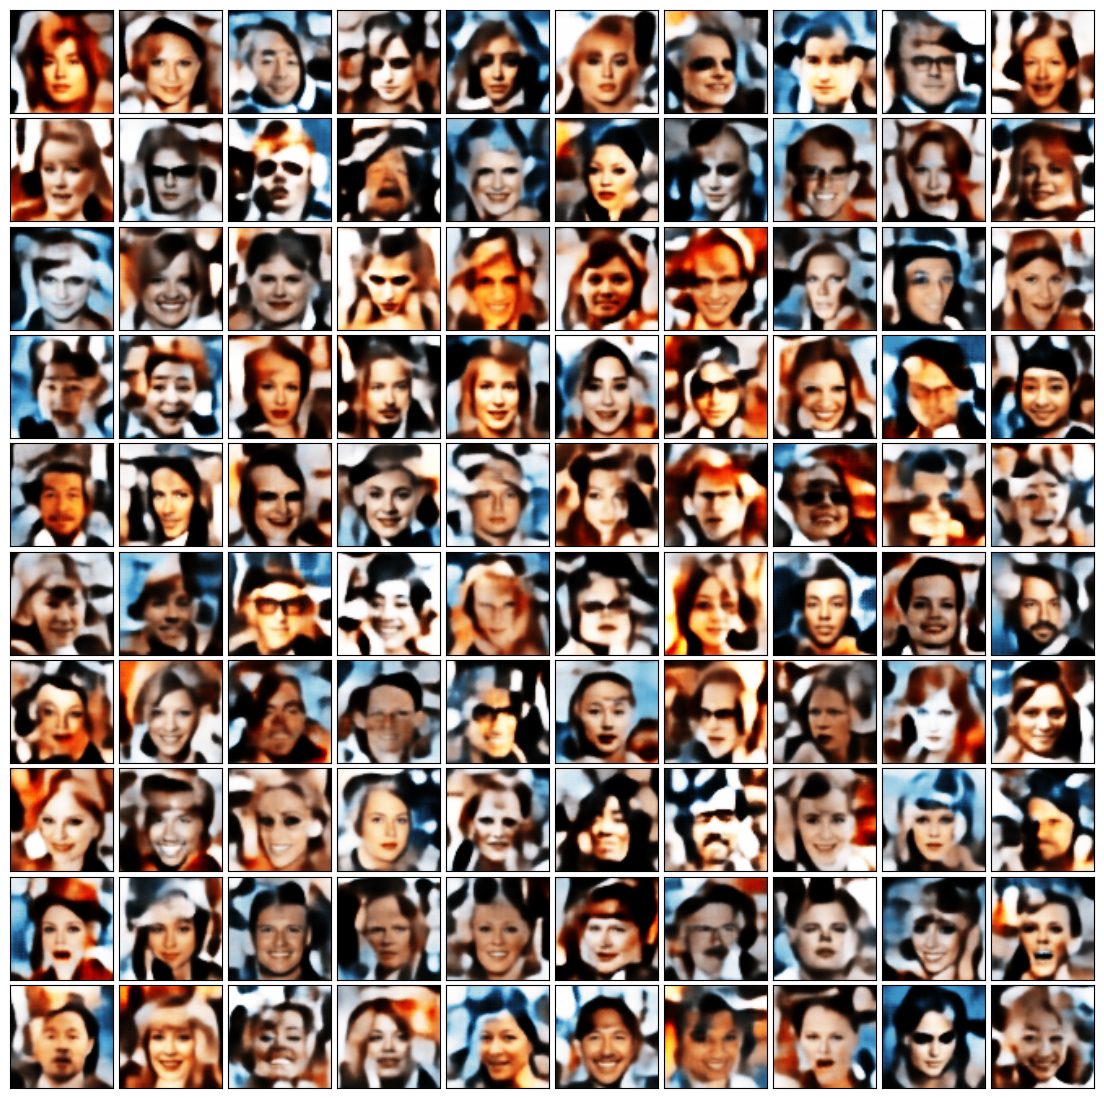

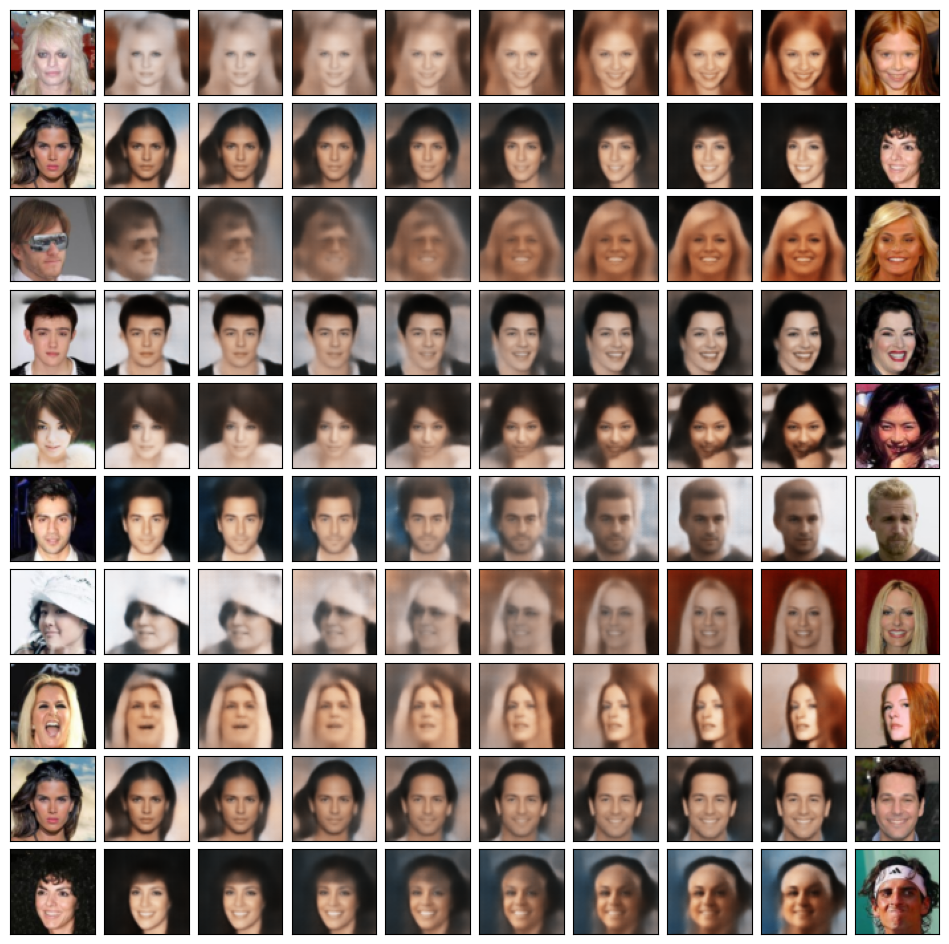

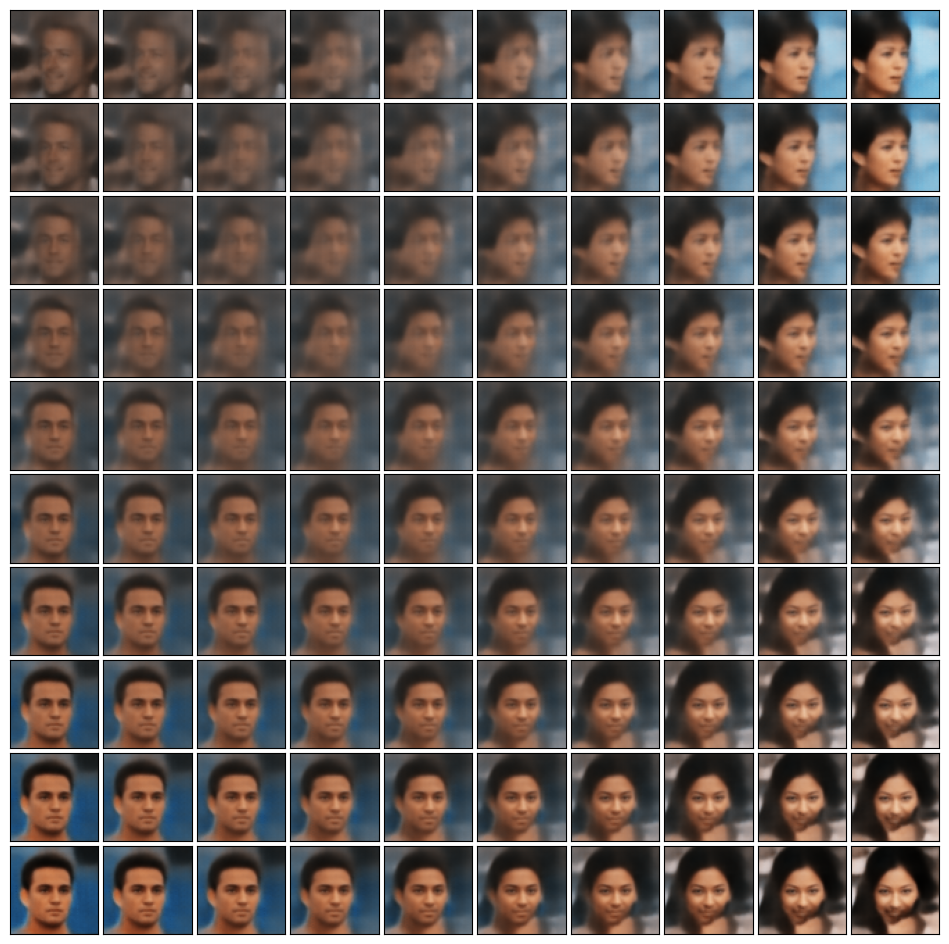

In [16]:

%run Evaluation_colab_version.ipynb


In [3]:
"""!pip install torch-summary"""

'!pip install torch-summary'

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torchvision.transforms as T
from torch import Tensor

from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
from PIL import Image

import os

print(os.getcwd()) # dosya yolunu ver
%run ../Model.ipynb
%run ../Dataset.ipynb


plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

/arf/home/tunal/ondemand/PhD Thesis Starting/01_SON/Tik-4/Tez/08-CelebA-Copy2/02-UAE_for_CelebA


In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [5]:
class Trainer:
    def __init__(self, model, optimizer, device='cpu', max_patience=20):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.device = device

        self.max_patience = max_patience
        self.best_val_loss = float('inf')
        self.patience = 0

        self.val_cost = []
        self.train_cost = []

    def train(self, train_loader, val_loader=None, epochs=10, print_every=1, name=None):
        self.model.train()

        for epoch in range(1, epochs + 1):
            total_loss = 0.0
            count_batch = 0.0
            for x, x_ in train_loader:  # label kullanılmıyor
                count_batch += 1
                if count_batch % 10 == 0:
                  print(count_batch)

                x = x.to(self.device)
                x_ = x_.to(self.device)

                with torch.no_grad():
                    z_hat_ = self.model.encoder(x_)
                z_hat, x_hat = self.model(x)

                loss = self.model.criterion(z_pred=z_hat_, z_true=z_hat, x_pred=x_hat, x_true=x)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()


            # Validation
            if val_loader:
                val_loss = self.validate(val_loader)

                # Early stopping kontrolü
                if val_loss < self.best_val_loss:
                    print('saved!')
                    torch.save(self.model, name + '.model')
                    self.best_val_loss = val_loss
                    self.patience = 0

                else:
                    self.patience = self.patience + 1

                if self.patience > self.max_patience:
                    break

            if epoch % print_every == 0:
                print(f"Epoch {epoch:3d} | Train Loss: {total_loss / len(train_loader):.6f} | Validation Loss: {val_loss:.6f}")

            self.val_cost.append(val_loss)
            self.train_cost.append(total_loss / len(train_loader))

            #torch.cuda.empty_cache()
            #torch.cuda.ipc_collect()

    def validate(self, val_loader):
        self.model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for x, x_ in val_loader:
                x = x.to(self.device)
                x_ = x_.to(self.device)

                z_hat_ = self.model.encoder(x_)
                z_hat, x_hat = self.model(x)

                loss = self.model.criterion(z_pred=z_hat_, z_true=z_hat, x_pred=x_hat, x_true=x)

                total_loss += loss.item()

        avg_loss = total_loss / len(val_loader)
        #print(f"→ Validation Loss: {avg_loss:.6f}")
        self.model.train()
        return avg_loss

In [6]:
# Custom Transform
class NoiseTransform:
    """Görüntü verisine Gaussian gürültü ekler."""

    def __init__(self, split_ratio=0.001):
        self.split_ratio = split_ratio

    def __call__(self, x):
        return x + self.split_ratio * torch.randn_like(x)

In [7]:
# Hyper-Parameters & Settings

batch_size = 128
lr = 0.0003

epochs = 50
max_patience = 50

split_ratio = 0.0001

In [9]:
# Veri yolu
root_dir = '../data/img_align_celeba'

train_dataset = CelebADataset(img_dir=root_dir, attr_path='../data/list_attr_celeba.csv', partition_path='../data/list_eval_partition.csv' , mode='train', NoiseTransform=NoiseTransform(split_ratio))
val_dataset   = CelebADataset(img_dir=root_dir, attr_path='../data/list_attr_celeba.csv', partition_path='../data/list_eval_partition.csv', mode='val', NoiseTransform=NoiseTransform(split_ratio))
test_dataset  = CelebADataset(img_dir=root_dir, attr_path='../data/list_attr_celeba.csv', partition_path='../data/list_eval_partition.csv', mode='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=len(val_dataset))
test_loader  = DataLoader(test_dataset, batch_size=len(test_dataset))

In [10]:
len(train_dataset)

162770

In [10]:
# "results" klasörünü oluştur (zaten varsa hata vermez)
os.makedirs("results", exist_ok=True)
# Model
name = 'results/UAE_CelebA_HQ'
# Model oluştur
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = To_Uniform(input_channels=3, latent_dim=100, output_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

from torchsummary import summary
summary(model, input_size=(3, 64, 64))

In [11]:
from torchsummary import summary
summary(model, input_size=(3, 64, 64))

Layer (type:depth-idx)                   Param #
├─SimpleEncoder: 1-1                     --
|    └─Conv2d: 2-1                       896
|    └─BatchNorm2d: 2-2                  64
|    └─Conv2d: 2-3                       32,832
|    └─BatchNorm2d: 2-4                  128
|    └─Conv2d: 2-5                       131,200
|    └─BatchNorm2d: 2-6                  256
|    └─Conv2d: 2-7                       524,544
|    └─BatchNorm2d: 2-8                  512
|    └─Conv2d: 2-9                       2,097,664
|    └─BatchNorm2d: 2-10                 1,024
|    └─Sequential: 2-11                  --
|    |    └─Linear: 3-1                  16,779,264
|    |    └─SiLU: 3-2                    --
|    |    └─BatchNorm1d: 3-3             4,096
|    |    └─Linear: 3-4                  204,900
|    |    └─Sigmoid: 3-5                 --
├─SimpleDecoder: 1-2                     --
|    └─Sequential: 2-12                  --
|    |    └─Linear: 3-6                  206,848
|    |    └─ReLU: 3-7 

Layer (type:depth-idx)                   Param #
├─SimpleEncoder: 1-1                     --
|    └─Conv2d: 2-1                       896
|    └─BatchNorm2d: 2-2                  64
|    └─Conv2d: 2-3                       32,832
|    └─BatchNorm2d: 2-4                  128
|    └─Conv2d: 2-5                       131,200
|    └─BatchNorm2d: 2-6                  256
|    └─Conv2d: 2-7                       524,544
|    └─BatchNorm2d: 2-8                  512
|    └─Conv2d: 2-9                       2,097,664
|    └─BatchNorm2d: 2-10                 1,024
|    └─Sequential: 2-11                  --
|    |    └─Linear: 3-1                  16,779,264
|    |    └─SiLU: 3-2                    --
|    |    └─BatchNorm1d: 3-3             4,096
|    |    └─Linear: 3-4                  204,900
|    |    └─Sigmoid: 3-5                 --
├─SimpleDecoder: 1-2                     --
|    └─Sequential: 2-12                  --
|    |    └─Linear: 3-6                  206,848
|    |    └─ReLU: 3-7 

In [12]:
# Training
trainer = Trainer(model, optimizer, device='cuda' if torch.cuda.is_available() else 'cpu', max_patience=max_patience)
trainer.train(train_loader, val_loader, epochs=epochs, name=name)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
160.0
170.0
180.0
190.0
200.0
210.0
220.0
230.0
240.0
250.0
260.0
270.0
280.0
290.0
300.0
310.0
320.0
330.0
340.0
350.0
360.0
370.0
380.0
390.0
400.0
410.0
420.0
430.0
440.0
450.0
460.0
470.0
480.0
490.0
500.0
510.0
520.0
530.0
540.0
550.0
560.0
570.0
580.0
590.0
600.0
610.0
620.0
630.0
640.0
650.0
660.0
670.0
680.0
690.0
700.0
710.0
720.0
730.0
740.0
750.0
760.0
770.0
780.0
790.0
800.0
810.0
820.0
830.0
840.0
850.0
860.0
870.0
880.0
890.0
900.0
910.0
920.0
930.0
940.0
950.0
960.0
970.0
980.0
990.0
1000.0
1010.0
1020.0
1030.0
1040.0
1050.0
1060.0
1070.0
1080.0
1090.0
1100.0
1110.0
1120.0
1130.0
1140.0
1150.0
1160.0
1170.0
1180.0
1190.0
1200.0
1210.0
1220.0
1230.0
1240.0
1250.0
1260.0
1270.0
saved!
Epoch  12 | Train Loss: 0.006026 | Validation Loss: 0.005780
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
160.0
170.0
180.0
190.0
200.0
210.0
220.0
2

In [14]:
# CSV dosyasına kaydet
train_losses = trainer.train_cost  # liste veya numpy array
val_losses = trainer.val_cost

np.savetxt("results/losses.csv",
           np.column_stack((train_losses, val_losses)),
           delimiter=",",
           header="train_loss,val_loss",
           comments="")